# Importing useful packages and libraries

In [0]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
import pandas  as pd
from sklearn.preprocessing import  scale
import seaborn as sns
import cv2
from copy import deepcopy
from math import ceil
from google.colab import drive
import imageio
colab = True
user = "jean"

In [0]:
root_path = 'gdrive/My Drive/prime_project/data/'

if user=="Francesco":
  if colab:
    root_path = 'gdrive/My Drive/Colab Notebooks/prime_project/data/'
  else:
    root_path = '../The BeeImage Dataset from Kaggle/'

drive.mount('/content/gdrive') 
directory =  root_path+"/bee_imgs/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Perliminary EDA

We the read the *.csv* file containing metadata about The BeeImage Dataset.

In [0]:
df = pd.read_csv(root_path+"bee_data.csv")
n_tot = df['file'].count()
print("Total images in the dataset: {}".format(n_tot))
df.head()

Total images in the dataset: 5172


,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


For the purposes of the current work, we are only interested in associating each bee to the proper subspecies. For this reason, we are going to discard the images representing bees whose subspecies is unknown.

Images left: 4744
Images lost: 8.275328692962105%
Distinct values of subspecies = 6



Text(0.5, 0, 'Frequency')

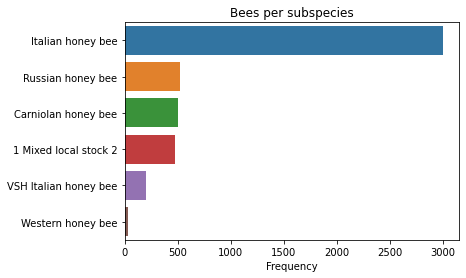

In [0]:
df = df[df['subspecies'] != '-1'] # remove images for which we do not have the class label
print("Images left: {}\nImages lost: {}%".format(df['file'].count(), 100-df['file'].count()/n_tot*100))
print("Distinct values of subspecies = {}\n".format(df["subspecies"].nunique()))
# print("Counting the distinct values of subspecies:\n{}".format(df["subspecies"].value_counts()))

subspecies_counts = df["subspecies"].value_counts()
plt.title("Bees per subspecies")
g = sns.barplot(x = subspecies_counts, y = subspecies_counts.index)
g.set_xlabel("Frequency")

# Loading images and pre-processing

In [0]:
def get_image_data(directory,files):
    '''Returns np.ndarray of images read from the image data directory'''
    # IMAGE_FILE_ROOT = '../data/bee_imgs/' 
    return np.asanyarray([imageio.imread("{}{}".format(directory, file)) for file in files])

def load_images(directory, files):
    '''Load images from disk'''
    X = []
    for img_name in files:
        img = cv2.imread(directory + img_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = np.array(img)
        X.append(img)
    X = np.array(X)
    return X

def show_image_shapes(images,n):
    '''Print the shape of n images randomly chosen'''
    for i in range(n):
        r = np.random.randint(low=0, high=len(images))
        print("image number {} has shape = {}".format(r, images[r].shape))

def show_image(image, ax = plt, title = None, show_size = False):
    '''Plots a given np.array image'''
    ax.imshow(image)
    if title:
        if ax == plt:
            plt.title(title)
        else:
            ax.set_title(title)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
        
def show_images(images, titles = None, show_size = False):
    '''Plots many images from the given list of np.array images'''
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(images)/cols)),ncols=cols, figsize=(14,5))
    ax = ax.flatten()
    for i, image in enumerate(images):
        if titles:
            show_image(image, ax = ax[i], title = titles[i], show_size = show_size)
        else:
            show_image(image, ax = ax[i], title = None, show_size = show_size)
    plt.show()       

Firstly we load the images.

In [0]:
%time images = load_images(directory, df.file.values)
# %time images = get_image_data(directory,df.file.values)

CPU times: user 1.96 s, sys: 1.14 s, total: 3.1 s
Wall time: 14.5 s


Then we display some images and their shape.

In [0]:
show_image_shapes(images,5)

image number 1154 has shape = (65, 43, 3)
image number 3116 has shape = (57, 56, 3)
image number 3534 has shape = (72, 62, 3)
image number 3992 has shape = (64, 54, 3)
image number 1913 has shape = (53, 44, 3)


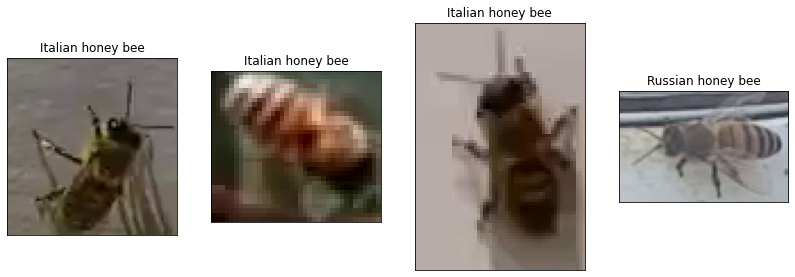

In [0]:
show_images(images[::1200],list(df["subspecies"][::1200]))

As we can see from the previous outputs, images basically have different shapes. However, in order to train our CNN, all input images should have the same shape. Therefore, we need to reshape them somehow. Basically we have the following possibilities:

 * reshape all images to **the smallest image size**: applying this technique will lead to huge loss in data quality, which is not acceptable in our case since images already have a very low quality;

 * reshape all images to **the highest image size**: this technique may lead to noisy images and the network may not learn anything at all.


Here we propose an approch who finds **the most frequent image shape** and use to reshape the other images. The intuition behind this technique is that it may allow to reshape only few images therefore, preserving data quality for most of our images.

Furthermore, the original aspect ratio may not fit into the one forced by the new shape. Eventually, reshaping can be carried out in two different ways:

 * by **shrinking and stretching** the original image up to the requested shape;

 * by **preserving the original aspect ratio** by adding black pixels as padding.

In the following we will implement both techniques to test which is the best one.


## Finding the most frequent image shape

In [0]:
def get_images_wh(images):
    '''Returns a tuple of lists, representing the widths and heights of the given images, respectively.'''
    widths = []
    heights = []
    for image in images:
        h, w, rbg = image.shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

def get_best_average(dist, cutoff = .5):
    '''Returns an integer of the average from the given distribution above the cutoff.
    '''
    # requires single peak normal-like distribution
    hist, bin_edges = np.histogram(dist, bins = 25);
    total_hist = sum(hist)
    
    # associating proportion of hist with bin_edges
    hist_edges = [(vals[0]/total_hist,vals[1]) for vals in zip(hist, bin_edges)]
    
    # sorting by proportions (assumes normal-like dist such that high freq. bins are close together)
    hist_edges.sort(key = lambda x: x[0])
    lefts = []
    
    # add highest freq. bins to list up to cutoff % of total
    while cutoff > 0:
        vals = hist_edges.pop()
        cutoff -= vals[0]
        lefts.append(vals[1])
        
    # determining leftmost and rightmost range, then returning average
    diff = np.abs(np.diff(lefts)[0]) # same diff b/c of bins
    leftmost = min(lefts)
    rightmost = max(lefts) + diff
    return int(np.round(np.mean([rightmost,leftmost])))

In [0]:
wh = get_images_wh(images)

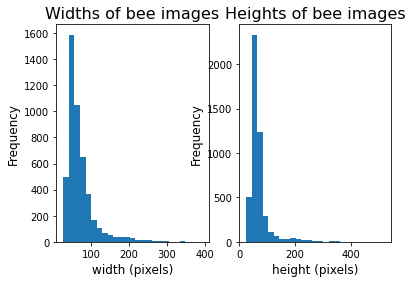

In [0]:
size = 12
plt.subplot(1,2,1)
plt.title("Widths of bee images", fontsize = size * 4/3, pad = size/2)
plt.ylabel("Frequency", size = size)
plt.xlabel("width (pixels)", size = size)
plt.hist(wh[0], bins = 25);

plt.subplot(1,2,2)
plt.title("Heights of bee images", fontsize = size * 4/3, pad = size/2)
plt.ylabel("Frequency", size = size)
plt.xlabel("height (pixels)", size = size)
plt.hist(wh[1], bins = 25);

We can notice that the distribution of **width** and **height** of images is very biased towards small values. So we will consider only the $50 \%$ most frequent values for **weigth** and **height**, then we will average them to determine the shape of our input images. This technique will allow to alter the least majority of the data.

*NOTE*: we could have defined **width** and **height** as the average over the width and shape of all the images. However, this technique should have not been efficient since the distrinution of the two variables is mainly concentrated around the interval $[48, 78]$.

In [0]:
ideal_width, ideal_height = get_best_average(wh[0]), get_best_average(wh[1])
print("the ideal height and width for our images are ",ideal_height,ideal_width) 

the ideal height and width for our images are  64 56


## Resizing the images

In order to resize our images, we can use the package *opencv* which already implement some useful functions to resize an image. 

In [0]:
def resize_images_stretching(images,new_shape):
    """
    resize the entire data set of images
        @input
            - images: ndarray of shape=(n_images,) where each image is of shape (height,width,n_channel)
            - new_shape : a tuple (height,width)
        @returns:
            an ndarray representing the reshaped image dataset
    """
    size = (new_shape[1], new_shape[0]) # because dsize should be (width,height)
    reshaped_images = []
    for image in images:
        image = cv2.resize(src=image, dsize= size, interpolation = cv2.INTER_AREA)
        reshaped_images.append(image)  
    return np.asarray(reshaped_images)

def resize_images_padding(images, desired_size=64):
    """
    resize the entire data set of images with black padding
    in order to the aspect ratio
        @input
            - images: ndarray of shape=(n_images,) where each image is of shape (height,width,n_channel)
            - desired_size : an int
        @returns:
            an ndarray representing the reshaped image dataset
    """
    reshaped_images = []
    color = [0, 0, 0]

    for img in images:
        old_size = img.shape[:2]
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        img = cv2.resize(img, (new_size[1], new_size[0]))

        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        reshaped_images.append(new_img)

    return np.asarray(reshaped_images)

def dataset_statistics(images):
    print("The total number of images is :",len(images))
    s = images[0].shape
    uniform = True
    for i in images:
        if i.shape != s:
            uniform = False
    if uniform:
        print("All images have the same shape which is ",s)
    else:
        print("WARNING: all images does not have the same shape,therefore it's not possible to train a CNN")     

In [0]:
black_padding = False
def reshape_stretching_padding(images,ideal_height,ideal_width,nb_channels,black_padding):
  """reshape the image data set using the dimenssions passed as argument
  @input:
   -images: ndarray of shape(n,hiegth,width,channels) representing the data set of images
   -ideal_height: integer representing the height
   -ideal_widht: integer representing the width
   -nb_channels: integer representing the number of channels
   -black_padding: boolean indicating wether to reshape using blackpadding or stretching

  @return:
  an ndarray of shape (n,ideal_heigth,ideal_width,nb_channels) representing the reshaped images 
  """

  if black_padding:
    new_shape = (ideal_height,ideal_height, 3)
    reshaped_images = resize_images_padding(images,ideal_height)
  else:
    new_shape = (ideal_height,ideal_width, 3)
    reshaped_images = resize_images_stretching(images,new_shape)
  return reshaped_images,new_shape 
reshaped_images,new_shape = reshape_stretching_padding(images,ideal_height,ideal_width,3,black_padding)


We define a function to normalize the images in the interval $[0, 255]$. This might improve the accuracy.

In [0]:
def normalize_images(X):
    res = []
    for i in range(X.shape[0]):
        res.append(cv2.normalize(X[i], 0, 255, norm_type=cv2.NORM_MINMAX))
    return np.array(res)

The total number of images is : 4744
All images have the same shape which is  (64, 56, 3)


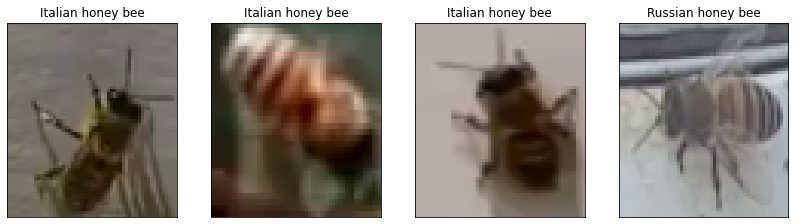

In [0]:
# reshaped_images = normalize_images(reshaped_images) # it's strange that normalizing mess the training process. we need to understand why ??
dataset_statistics(reshaped_images)
show_images(reshaped_images[::1200],list(df["subspecies"][::1200]))

We also need to encode the labels with integer values.

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

le = LabelEncoder()
labels = df.subspecies.values
encoded_labels = le.fit_transform(labels)
y = to_categorical(encoded_labels)

Now we can finally split the data for training and testing purposes.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(reshaped_images, y, test_size=0.2, random_state=2020)

In [0]:
print("X_train.shape = {}\nX_test.shape = {}\ny_train.shape = {}\ny_test.shape ={}"
      .format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))

X_train.shape = (3795, 64, 56, 3)
X_test.shape = (949, 64, 56, 3)
y_train.shape = (3795, 6)
y_test.shape =(949, 6)


# Building the CNN with Keras

The rules used in order to decide the network archtechture were the following:

1- New dataset is small and similar to original dataset. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.

2-New dataset is large and similar to the original dataset. Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.

3-New dataset is small but very different from the original dataset. Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.

4-New dataset is large and very different from the original dataset. Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

in our case, since we have a small dataset and there is No network trained on a similar classification task, we decided to define our onw CNN Architechture.






In [0]:
# !pip install tensorflow==1.14.0
# !pip install --ignore-installed --upgrade keras
import tensorflow as tf

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
print(keras.__version__)

2.3.1


In the following we will use image generators in order to load data. Data generators are on-the-fly image transformers and are the recommended way of providing image data to models in Keras. They let you work with on-disk image data too large to fit all at once in-memory. They allow also to preprocess the images the model sees with random image transformations and standardizations, a key technique for improving model performance. For more see https://keras.io/preprocessing/image/.

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)


In [0]:
img_rows, img_cols, nb_channels = new_shape
input_shape = (img_rows, img_cols, nb_channels)
nb_classes = Y_train.shape[1]

nb_filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)

model = Sequential()
model.add(Conv2D(
    filters = nb_filters, 
    kernel_size = kernel_size, 
    activation='relu',
    padding= "same",
    kernel_initializer = "glorot_normal", 
    input_shape = input_shape,
    name = "conv_1"
))
model.add(Conv2D(
    filters = nb_filters,
    kernel_size = kernel_size,
    activation='relu',
    padding ="same",
    kernel_initializer = "glorot_normal",
    name='conv_2'
))
model.add(MaxPooling2D((2, 2), name="max_pool_2"))
model.add(Conv2D(
    filters = nb_filters,
    kernel_size = kernel_size,
    activation='relu',
    padding ="same",
    kernel_initializer= "glorot_normal",
    name='conv_3'
))
model.add(MaxPooling2D((2, 2), padding="same", name = "max_pool_3"))
model.add(Flatten())
model.add(Dense(
    nb_classes,
    activation='softmax',
    kernel_initializer="glorot_normal",
    name='dense'
))

Now we compile the model, define the loss and the optimizer.

In [0]:
learning_rate = 0.001

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate),
              metrics=['accuracy'])

Finally we define a function to plot the accuracy and the loss over epochs and another one to plot the confusion matrix.

In [0]:
def plot_acc_loss(history, separate_plots = True):
    """
    plot the accuracy and the loss over epchos
        @input:
            - acc : array of shape=(n_epochs,) representing the accuracy of the model during training over epochs
            - loss: array of shape=(n_epochs,) representing the loss of the model during training
    """
    if separate_plots == True:
        plt.plot(history['accuracy'], 'g', label="train_acc")
        plt.plot(history['loss'], 'r', label="train_loss")
        plt.xlabel("epoch")
        plt.ylabel("metric")
        plt.legend()
        plt.show()

        plt.plot(history['val_accuracy'], 'g', label="val_acc")
        plt.plot(history['val_loss'], 'r', label="val_loss")
        plt.xlabel("epoch")
        plt.ylabel("metric")
        plt.legend()
        plt.show()
    else:
        plt.plot(history['acc'], 'g', label="train_acc")
        plt.plot(history['loss'], 'r', label="train_loss")
        plt.plot(history['val_acc'], 'g', label="val_acc")
        plt.plot(history['val_loss'], 'r', label="val_loss")
        plt.xlabel("epoch")
        plt.ylabel("metric")
        plt.legend()
        plt.show()

In [0]:
def plot_confusion_matrix(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis = 1)
    Y_true = np.argmax(Y_test, axis = 1)
    confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

We get the summary of the model so that we can have an idea of the architechture and the weigths that will be trained.

In [0]:
'''
the number of trainable of parameters at each layers is equal to
the total number of weight of all the filters at each layer;
in this case 3*3*(size of each filter) *
    3*(depth of each filter) *
    32*(total number of filters at the first layer) +
    32(each filter has a bias) = 896
'''
model.summary()
model_copy = deepcopy(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 56, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 56, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 32, 28, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 32, 28, 32)        9248      
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 16, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                

Finally we train the model.

In [0]:
n_epochs = 30
batch_size = 128

model = deepcopy(model_copy)
history = model.fit(
    train_datagen.flow(x= X_train, y = Y_train, batch_size=batch_size, shuffle=True),
    validation_data = (X_test, Y_test),
    steps_per_epoch=ceil(len(X_train)/ batch_size),
    epochs=n_epochs,
    verbose = 1
)

Epoch 1/30
30/30 [==============================] - 9s 314ms/step - loss: 7.6315 - accuracy: 0.5958 - val_loss: 0.6921 - val_accuracy: 0.7176
Epoch 2/30
30/30 [==============================] - 4s 126ms/step - loss: 0.4973 - accuracy: 0.8058 - val_loss: 0.3358 - val_accuracy: 0.8599
Epoch 3/30
30/30 [==============================] - 4s 126ms/step - loss: 0.3369 - accuracy: 0.8603 - val_loss: 0.2874 - val_accuracy: 0.8662
Epoch 4/30
30/30 [==============================] - 4s 125ms/step - loss: 0.3013 - accuracy: 0.8719 - val_loss: 0.2707 - val_accuracy: 0.8641
Epoch 5/30
30/30 [==============================] - 4s 124ms/step - loss: 0.2573 - accuracy: 0.8891 - val_loss: 0.2470 - val_accuracy: 0.8904
Epoch 6/30
30/30 [==============================] - 4s 125ms/step - loss: 0.2504 - accuracy: 0.8870 - val_loss: 0.2471 - val_accuracy: 0.8978
Epoch 7/30
30/30 [==============================] - 4s 126ms/step - loss: 0.3440 - accuracy: 0.8572 - val_loss: 0.2867 - val_accuracy: 0.8778
Epoch 

We can now evaluate the performances of the model on test data.

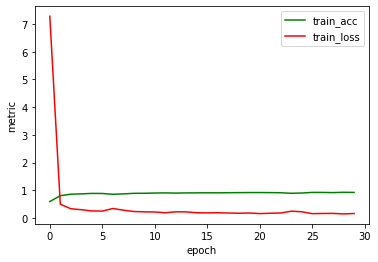

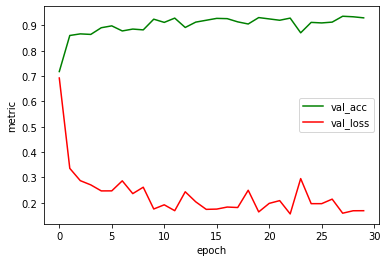

In [0]:
plot_acc_loss(history.history)

In the end, we plot accuracy and the loss over epochs during training.

Plotting the confusion matrix  might be useful in order to evaluate the overall performance of the network.

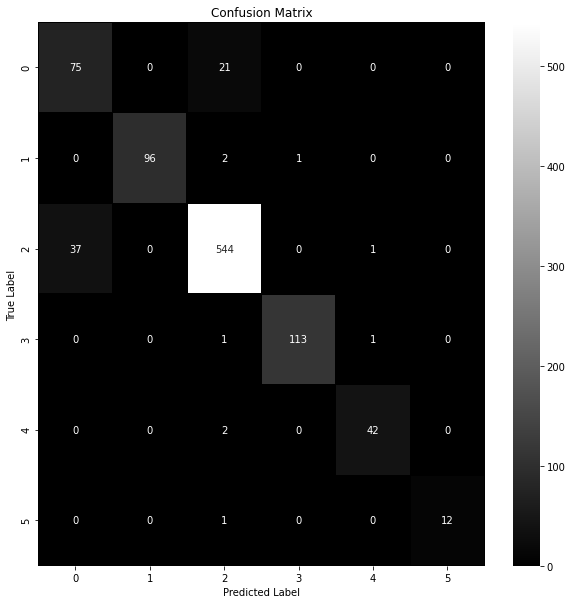

In [0]:
plot_confusion_matrix(model, X_test, Y_test)

As first interpretation, we can notice that the bias we had in input is replicated in output because the model learns very well how to predict **Italian honey bee** since it's the dominant class in the dataset. Moreover, the classifer tends to classify rare classes as belonging to **Italian honey bee class** as we can see from column 2 of the confusion matrix. **----------------------->** 

**NEW** This interpretaion is no more true anymore because the problem was **the scaling factor** in the image generator which was messing up the training process. We can even notice from the confusion matrix how the classifier performs quite well on all the classes,because it has a low misprediction rate.

# Targeting data scarcity with focused data augmentation

In the following we will consciously apply data augementation in order to take into account the actual data distribution. We already know that the dataset is strongly biased towards **Italian honey bee** class. Therefore, we might want to assign **weights** to each class during training, so that we end up paying more attention to rare classes. We can use 2 completely equivalent stategies:


*   passing a dictionary associating a given weight to each class to *fit_generator* function, so that it can compute the loss accordingly;
*   generating weighted samples by means of *ImageDataGenerator* itelsef, so that it can output batches of *(inputs, targets, sample_weights)*.


From an implementative point of view, the difference is that first method uses weights for each class while the second one needs weights for each sample in the training dataset. However, both method are practically the same.

In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(encoded_labels), encoded_labels)
class_weight_dict = dict(enumerate(class_weights))
sample_weights = class_weight.compute_sample_weight('balanced', encoded_labels)
print("class_weights : {}\nclass_weights.shape: {}\nclass_weights_dict : {}\nsample_weights.shape : {}\ny.shape : {}"
        .format(class_weights, class_weights.shape, class_weight_dict, sample_weights.shape, y.shape))

class_weights : [ 1.67514124  1.57817698  0.26285461  1.50031626  3.97319933 21.36936937]
class_weights.shape: (6,)
class_weights_dict : {0: 1.6751412429378532, 1: 1.5781769793745841, 2: 0.262854609929078, 3: 1.5003162555344718, 4: 3.9731993299832498, 5: 21.36936936936937}
sample_weights.shape : (4744,)
y.shape : (4744, 6)


In [0]:
X_train, X_test, Y_train, Y_test, sample_weights_train, sample_weights_test = train_test_split(reshaped_images, y, sample_weights, test_size=0.2, random_state=2020)
print("X_train.shape = {}\nX_test.shape = {}\ny_train.shape = {}\ny_test.shape = {}\nsample_weights_train.shape = {}\nsample_weights_test.shape = {}"
      .format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape,sample_weights_train.shape, sample_weights_test.shape))

X_train.shape = (3795, 64, 56, 3)
X_test.shape = (949, 64, 56, 3)
y_train.shape = (3795, 6)
y_test.shape = (949, 6)
sample_weights_train.shape = (3795,)
sample_weights_test.shape = (949,)


Now that we have both *class_weights* and *sample_weights* we can train the model again taking into account the actual classes' distribution. It's possible to switch between the first and the second implementation by means of *weighted_data_augmentation* flag.

In [0]:
n_epochs = 20
batch_size = 128

model = deepcopy(model_copy)
train_datagen.fit(X_train)
weighted_data_augmentation = True
if not weighted_data_augmentation:
    history = model.fit_generator(
        train_datagen.flow(x = X_train, y = Y_train, batch_size=batch_size, shuffle=True),
        validation_data = (X_test, Y_test, sample_weights_test),
        steps_per_epoch=ceil(len(X_train)/ batch_size),
        epochs=n_epochs,
        class_weight = class_weight_dict,
        verbose = 1
    )
else:
    history = model.fit_generator(
        train_datagen.flow(x = X_train, y = Y_train, batch_size=batch_size, shuffle=True, sample_weight=sample_weights_train),
        validation_data = (X_test, Y_test, sample_weights_test),
        steps_per_epoch=ceil(len(X_train)/ batch_size),
        epochs=n_epochs,
        verbose = 1
    )

Epoch 1/20
30/30 [==============================] - 4s 129ms/step - loss: 13.6458 - accuracy: 0.3647 - val_loss: 1.0013 - val_accuracy: 0.5142
Epoch 2/20
30/30 [==============================] - 4s 121ms/step - loss: 0.5566 - accuracy: 0.6754 - val_loss: 0.3568 - val_accuracy: 0.7492
Epoch 3/20
30/30 [==============================] - 4s 123ms/step - loss: 0.3280 - accuracy: 0.7573 - val_loss: 0.2720 - val_accuracy: 0.8061
Epoch 4/20
30/30 [==============================] - 4s 124ms/step - loss: 0.2691 - accuracy: 0.7800 - val_loss: 0.2627 - val_accuracy: 0.8567
Epoch 5/20
30/30 [==============================] - 4s 122ms/step - loss: 0.2773 - accuracy: 0.8011 - val_loss: 0.2468 - val_accuracy: 0.8599
Epoch 6/20
30/30 [==============================] - 4s 123ms/step - loss: 0.2409 - accuracy: 0.7989 - val_loss: 0.2357 - val_accuracy: 0.8156
Epoch 7/20
30/30 [==============================] - 4s 122ms/step - loss: 0.2118 - accuracy: 0.8324 - val_loss: 0.2632 - val_accuracy: 0.8314
Epoch

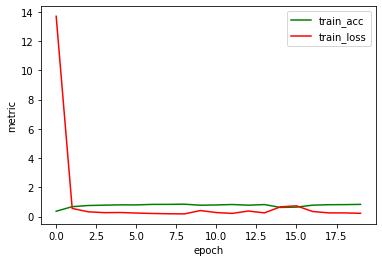

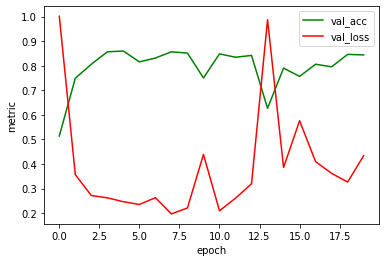

In [0]:
plot_acc_loss(history.history)

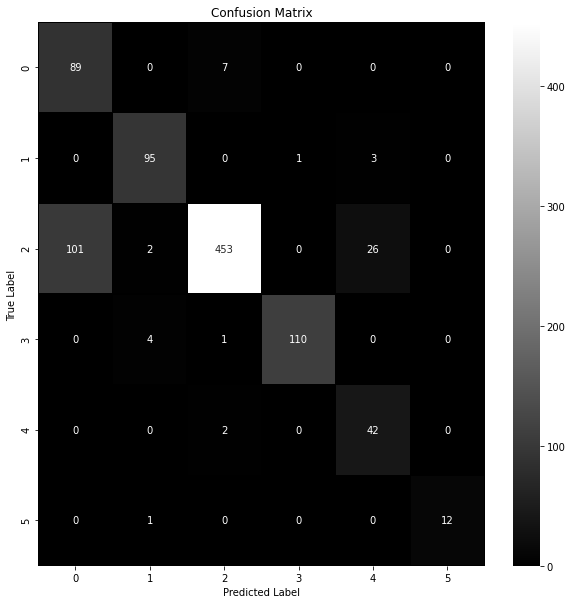

In [0]:
plot_confusion_matrix(model, X_test, Y_test)

Eventually, we notice that performances are not improved at all! Furthermore, the training got quite unstable and accuracy measure on training dataset seems to saturate. This behavior can be explained as excessive data shortage that cannot be filled by any data augmentation, not even a properly measured and weighted one. **-------------->** 

**NEW** This observation is no more true and the model seems to perform quite well on the minority classes because it has a low misprediction ratio as seen in the previous confusion matrix. While in the previous case, the misprediction for minority classes was higher. However, the overall accuracy is smaller than the initial one.

# Removing some bees to even the distribution

As we have seen in the previous section, data augmentation itself cannot face drammatic disparities in classes distribution. Therefore, we might embrace a different approach.

In the following, we are going to directly manage two critical classes from the dataset:


*   **Western honey bee** which has very few images that might be completely discarded;
*   **Italian honey bee** which is strongly dominant and can be shrunk.


Here are some numbers describing these issues.

In [0]:
print("Percentage of 'Western honey bee' images : {} %\nPercentage of 'Italian honey bee' images : {} %"
    .format(len(np.where(labels == "Western honey bee")[0])/len(labels) * 100, 
            len(np.where(labels == "Italian honey bee")[0])/len(labels) * 100))

Percentage of 'Western honey bee' images : 0.7799325463743676 %
Percentage of 'Italian honey bee' images : 63.40640809443507 %


Removing **Western honey bee** class can be done immediately.

In [0]:
reduced_reshaped_images = reshaped_images[labels != "Western honey bee"]
reduced_labels = labels[labels != "Western honey bee"]
print("Original dataset shape : {}\nReduced dataset shape : {}"
    .format(reshaped_images.shape, reduced_reshaped_images.shape))

Original dataset shape : (4744, 64, 56, 3)
Reduced dataset shape : (4707, 64, 56, 3)


Secondly, we want to randomly select a restricted amount of images belonging to **Italian honey bee** class. For instance, we can keep an amount of **Italian honey bee** images equal to the ones belonging to **Russian honey bee** class, that is the secont most frequent class in the dataset.

In [0]:
random_generator = np.random.RandomState(seed = 2020)

russian_number = len(np.where(reduced_labels == "Russian honey bee")[0])
print("Number of 'Russian honey bee' images : {}".format(russian_number))

rescued_italian_index = np.where(reduced_labels == "Italian honey bee")[0]
print("Total number of 'Italian honey bee' images before reducing : {}".format(len(rescued_italian_index)))
rescued_italian_index = random_generator.choice(rescued_italian_index, size=np.minimum(russian_number,len(rescued_italian_index)), replace=False)
rescued_italian = reduced_reshaped_images[rescued_italian_index]

reduced_reshaped_images = reduced_reshaped_images[reduced_labels != "Italian honey bee"]
reduced_reshaped_images = np.concatenate((reduced_reshaped_images, rescued_italian), axis=0)
reduced_labels = reduced_labels[reduced_labels != "Italian honey bee"]
reduced_labels = np.concatenate((reduced_labels, np.array(["Italian honey bee"]*len(rescued_italian))), axis=0)

print("reduced_reshaped_images.shape : {}\nreduced_label.shape : {}\nPercentage of 'Italian honey bee' images in the reduced dataset : {} %"
    .format(reduced_reshaped_images.shape,
            reduced_labels.shape,
            len(np.where(reduced_labels == "Italian honey bee")[0])/len(reduced_labels) * 100))

Number of 'Russian honey bee' images : 527
Total number of 'Italian honey bee' images before reducing : 3008
reduced_reshaped_images.shape : (2226, 64, 56, 3)
reduced_label.shape : (2226,)
Percentage of 'Italian honey bee' images in the reduced dataset : 23.67475292003594 %


We can visualize the result of the previous computations by a bar graph.

Text(0.5, 0, 'Frequency')

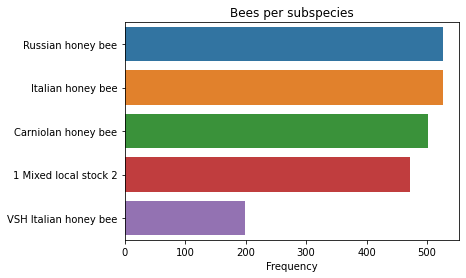

In [0]:
reduced_labels_df = pd.DataFrame(reduced_labels, columns = ['reduced_labels'])
reduced_subspecies_counts = reduced_labels_df['reduced_labels'].value_counts()
plt.title("Bees per subspecies")
g = sns.barplot(x = reduced_subspecies_counts, y = reduced_subspecies_counts.index)
g.set_xlabel("Frequency")

Next, we need to properly encode the reduced set of labels as we did in the first place.

In [0]:
reduced_le = LabelEncoder()
reduced_encoded_labels = reduced_le.fit_transform(reduced_labels)
reduced_y = to_categorical(reduced_encoded_labels)

In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(reduced_encoded_labels), reduced_encoded_labels)
class_weight_dict = dict(enumerate(class_weights))
sample_weights = class_weight.compute_sample_weight('balanced', reduced_encoded_labels)
print("class_weights : {}\nclass_weights.shape: {}\nclass_weights_dict : {}\nsample_weights.shape : {}\ny.shape : {}"
        .format(class_weights, class_weights.shape, class_weight_dict, sample_weights.shape, reduced_y.shape))

class_weights : [0.94322034 0.88862275 0.84478178 0.84478178 2.23718593]
class_weights.shape: (5,)
class_weights_dict : {0: 0.9432203389830508, 1: 0.888622754491018, 2: 0.8447817836812144, 3: 0.8447817836812144, 4: 2.2371859296482413}
sample_weights.shape : (2226,)
y.shape : (2226, 5)


As we can see, now we have $5$ classes that are almost uniformly distribuited (except for **VSH Italian honey bee** class). Nonetheless, in the following we are going to use sample weights during data augmentation anyway.

In [141]:
print(reduced_le.classes_) # The index of the class in the array will correspond the encoded label

['1 Mixed local stock 2' 'Carniolan honey bee' 'Italian honey bee'
 'Russian honey bee' 'VSH Italian honey bee']


In [0]:
X_train, X_test, Y_train, Y_test, sample_weights_train, sample_weights_test = train_test_split(reduced_reshaped_images, reduced_y, sample_weights, test_size=0.2, random_state=2020)
print("X_train.shape = {}\nX_test.shape = {}\ny_train.shape = {}\ny_test.shape = {}\nsample_weights_train.shape = {}\nsample_weights_test.shape = {}"
      .format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape,sample_weights_train.shape, sample_weights_test.shape))

X_train.shape = (1780, 64, 56, 3)
X_test.shape = (446, 64, 56, 3)
y_train.shape = (1780, 5)
y_test.shape = (446, 5)
sample_weights_train.shape = (1780,)
sample_weights_test.shape = (446,)


We need to refine CNN's architecture: in particular last **Dense** layer must have $5$ units instead of $6$, as we reduced the number of classes by $1$.

In [0]:
nb_classes = Y_train.shape[1]
model = deepcopy(model_copy)

model.pop()
model.add(Dense(
    nb_classes,
    activation='softmax',
    kernel_initializer="glorot_uniform",
    name='dense'
))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 56, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 56, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 32, 28, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 32, 28, 32)        9248      
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 16, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                

###Before training the model, we need to refit the datagenerator on the new dataset

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

In [0]:
n_epochs = 32
batch_size = 128

history1 = model.fit_generator(
    train_datagen.flow(x = X_train, y = Y_train, batch_size=batch_size, shuffle=True, sample_weight=sample_weights_train),
    validation_data = (X_test, Y_test, sample_weights_test),
    steps_per_epoch=ceil(len(X_train)/ batch_size),
    epochs=n_epochs,
    verbose = 1
)

Epoch 1/32
14/14 [==============================] - 2s 127ms/step - loss: 0.3145 - accuracy: 0.8624 - val_loss: 0.3374 - val_accuracy: 0.8610
Epoch 2/32
14/14 [==============================] - 2s 123ms/step - loss: 0.3416 - accuracy: 0.8652 - val_loss: 0.2723 - val_accuracy: 0.8744
Epoch 3/32
14/14 [==============================] - 2s 126ms/step - loss: 0.3105 - accuracy: 0.8629 - val_loss: 0.2878 - val_accuracy: 0.8879
Epoch 4/32
14/14 [==============================] - 2s 128ms/step - loss: 0.3208 - accuracy: 0.8640 - val_loss: 0.3019 - val_accuracy: 0.8879
Epoch 5/32
14/14 [==============================] - 2s 129ms/step - loss: 0.2856 - accuracy: 0.8803 - val_loss: 0.2991 - val_accuracy: 0.8744
Epoch 6/32
14/14 [==============================] - 2s 129ms/step - loss: 0.3040 - accuracy: 0.8713 - val_loss: 0.2594 - val_accuracy: 0.8901
Epoch 7/32
14/14 [==============================] - 2s 129ms/step - loss: 0.2877 - accuracy: 0.8860 - val_loss: 0.2985 - val_accuracy: 0.8767
Epoch 

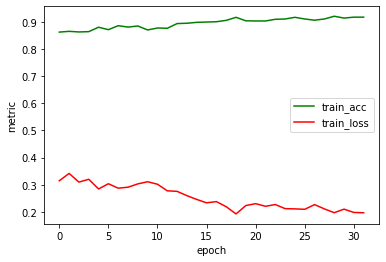

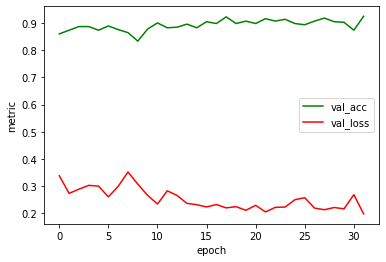

In [0]:
plot_acc_loss(history1.history)

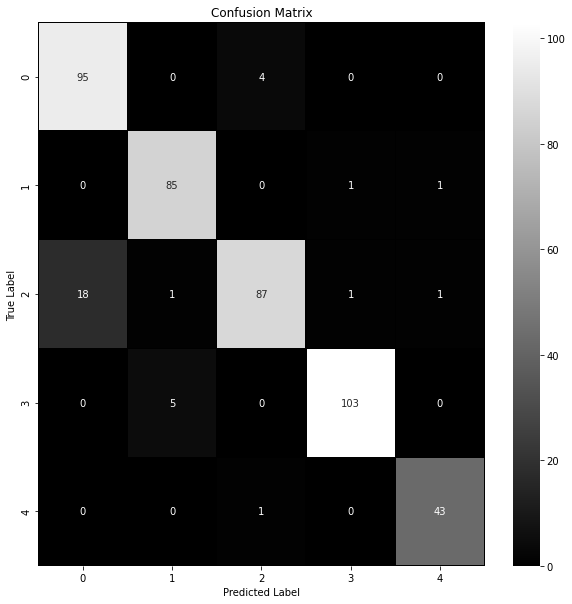

In [0]:
plot_confusion_matrix(model, X_test, Y_test)

Results are quite bad even with a data distribution that is almost uniform: **Italian honey bee** class is still getting all the prediction! We supposed that the images belonging to this class end up to monopolize the predictions because of some features that result dominant somehow. Therefore, we tried to normalize the dataset, but we obtained exactly the same inconsequential results. **----------->**

**NEW** The classifier is now performing quite well on all the classes since they have similar distributions. especially the quality of the classifier can be appreciated by looking the number of mispredictions for all the classes which is lower with respect to the original dataset.

#Apply Semi supervized learning to leverage unlabeled data and increase the size of the data set.

We have differents types of semi-supervized learning techniques.

the one we will be applying is decribed in the following:

* Take the same model that you used with your training set and that gave you good results.
* Use it now with your unlabeled test set to predict the outputs ( or pseudo-labels). We don’t know if these predictions are correct, but we do now have quite accurate labels and that’s what we aim in this step.
* Concatenate the training labels with the test set pseudo labels.
* Concatenate the features of the training set with the features of the test set.
Finally, train the model in the same way you did before with the training set.

for more details, [read the original paper](http://deeplearning.net/wp-content/uploads/2013/03/pseudo_label_final.pdf)
,[here is another technique not usefull in this case](https://arxiv.org/pdf/1704.03976.pdf)

In [0]:
def append_images(original_images,labels,new_images,model):
  """
   given a model, this function predict the labels for new images,remove itlian honey bees and append the rest to the original dataset in order to increase the size of the trainig dataset.
   @input:
   -original_images: ndarray of shape (n_images,width,height,n_channels)
   -labels: array of shape (n_original_images,) representing the label for those images
   -new_images: ndarray of shape (n_new__images,width,height,n_channels)
   -model: a CNN model used in order to predict the label of the ndarray new_images

   @returns
   -an ndarray of shape(n_original_images+n_new_images,width,height,n_channels)
   -an ndarray of the shape (n_original_images+n_new_images,n_classes) repsenting the labels of those images

   NB:The returned dataset may be lower du to removal of italian honey bees
  """

  new_labels = model.predict(new_images) 
  # remove images predicted as Italian honey bees ptherwise they wil biased the distribution
  new_images = new_images[np.where(np.argmax(new_labels,axis=1) != 2)[0]] 
  new_labels = new_labels[np.where(np.argmax(new_labels,axis=1) != 2)[0]]

  Y_train_soft = np.argmax(np.append(labels,new_labels,axis=0),axis=1) # Y_train_soft will be of shape (m,n_classes) and contains the probabilities of each class 
  Y_train_new =  to_categorical(Y_train_soft)
  X_train_new = np.append(original_images,new_images,axis=0)
  return X_train_new,Y_train_new

###load the data set labeled as bees labeled as P for pollen bearing, and NP for non pollen bearing

In [0]:
import glob, os
"""
"new_bees" is the name of the folder containing images of the data set labled as pollen bearing "P" and NP "for non pollen bearing"
"""
new_path= root_path+"new_bees" # just modify this with the folder's name of your bees.
imlist= glob.glob(os.path.join(new_path, '*.jpg'))
print("The number of new images is {%d}"%(len(imlist)))
print(imlist)

new_images = load_images("",imlist)#imlist already contains the absolute path, so directory should be empty

The number of new images is {135}
['gdrive/My Drive/prime_project/data/new_bees/NP832-7r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP1149-11r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP666-5r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP220-1r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP1387-5r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP1445-20r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP1300-17r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP1268-15r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP1245-13r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP1768-10r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP3121-34r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP2883-18r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP3309-36r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP1768-11r.jpg', 'gdrive/My Drive/prime_project/data/new_bees/NP1803-24r.jpg', 'gdrive/My Drive/prime_project/data/new_be

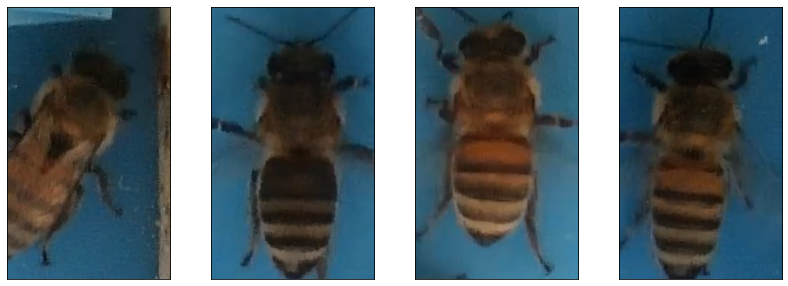

image number 117 has shape = (300, 180, 3)
image number 53 has shape = (300, 180, 3)
image number 18 has shape = (300, 180, 3)
image number 41 has shape = (300, 180, 3)
image number 94 has shape = (300, 180, 3)


In [0]:
show_images(new_images[::40])
show_image_shapes(new_images,5)

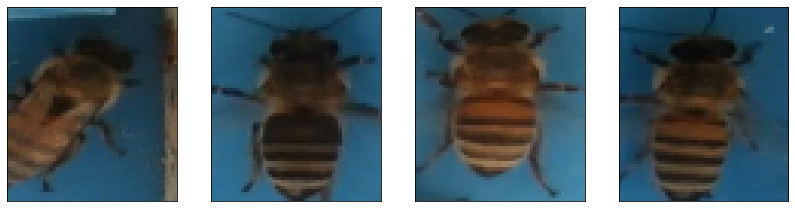

In [0]:
reshaped_new_images,new_shape = reshape_stretching_padding(new_images,ideal_height,ideal_width,3,black_padding=False)
show_images(reshaped_new_images[::40])

In [0]:
labels = np.argmax(model.predict(reshaped_new_images),axis=1)
print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


As seen here, the data set named "dataset" consitutued of bees labeled as **P** for pollen bearing, and **NP** for non pollen bearing mostly contains italian honey bees. So we can't use it for our semi supervized task because it will oncly increase the size of italian honey bees.

###import the dataset labeled as **bees**, **no_bees**

In [0]:
"""
"new_bees" is the name of the folder containing images of the data set labled as pollen bearing "P" and NP "for non pollen bearing"
"""
new_path= root_path+"new_bees1" # just modify this with the folder's name of your bees.
imlist= glob.glob(os.path.join(new_path, '*.png'))
print("The number of new images is {%d}"%(len(imlist)))
print(imlist)

new_images1 = load_images("",imlist)#imlist already contains the absolute path, so directory should be empty

The number of new images is {177}
['gdrive/My Drive/prime_project/data/new_bees1/1_51_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/14_1399_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/14_1255_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/14_454_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/14_1197_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/14_0_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/17_1454_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/19_1_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/14_655_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/14_1015_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/19_8_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/19_1274_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/19_2277_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/19_1182_yb.png', 'gdrive/My Drive/prime_project/data/new_bees1/19_32_yb.png', 'gdrive/My Drive/prime_project/data/

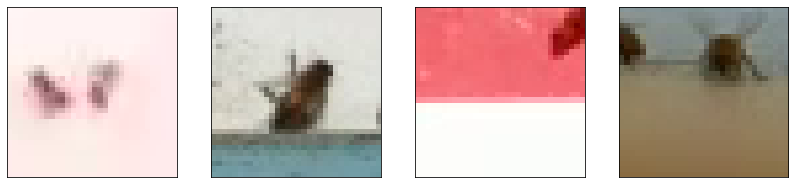

image number 161 has shape = (32, 32, 3)
image number 70 has shape = (32, 32, 3)
image number 139 has shape = (32, 32, 3)
image number 99 has shape = (32, 32, 3)
image number 42 has shape = (32, 32, 3)


In [0]:
show_images(new_images1[::50])
show_image_shapes(new_images1,5)

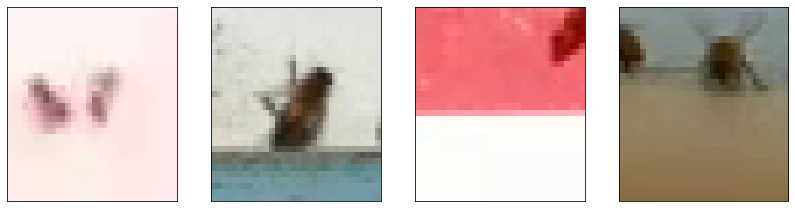

In [0]:
reshaped_new_images1,new_shape = reshape_stretching_padding(new_images1,ideal_height,ideal_width,3,black_padding=False)
show_images(reshaped_new_images1[::50])

In [0]:
labels = np.argmax(model.predict(reshaped_new_images1),axis=1)
print(labels)

[1 1 2 1 2 2 2 0 1 1 1 2 2 2 1 0 2 2 0 2 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 0 0
 2 0 2 2 2 0 2 2 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 0 2 2 3 2 2 2 2 2 2
 2 2 0 0 0 2 2 2 2 2 0 2 2 2 2 2 2 2 1 2 0 2 0 2 3 0 2 2 2 2 2 2 0 2 1 2 0
 0 0 4 0 0 0 1 0 0 0 0 0 3 0 2 0 0 0 2 0 1 0 3 2 0 0 3 2 2 2 4 3 0 2 2 2 2
 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 0 2 1 3 2 2 2 2 2 0]


This dataset seems to contains differents types of images, so it may be usefull to increase the training size.

###append the newly imported dataset to  the old **X_train**

In [0]:
X_train_new,Y_train_new = append_images(X_train,Y_train,reshaped_new_images1,model)
print(X_train_new.shape,Y_train_new.shape)

(1849, 64, 56, 3) (1849, 5)


###train a model with the new dataset

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train_new)

In [0]:
nb_classes = Y_train_new.shape[1]
model = deepcopy(model_copy)

model.pop()
model.add(Dense(
    nb_classes,
    activation='softmax',
    kernel_initializer="glorot_uniform",
    name='dense'
))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 56, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 56, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 32, 28, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 32, 28, 32)        9248      
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 16, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                

In [0]:
n_epochs = 10
batch_size = 3

history = model.fit_generator(
    train_datagen.flow(x = X_train_new, y = Y_train_new, batch_size=batch_size, shuffle=True),
    validation_data = (X_test, Y_test, sample_weights_test),
    steps_per_epoch=ceil(len(X_train)/ batch_size),
    epochs=n_epochs,
    verbose = 1
)

Epoch 1/10
56/56 [==============================] - 2s 36ms/step - loss: 0.2592 - accuracy: 0.8964 - val_loss: 0.1831 - val_accuracy: 0.9193
Epoch 2/10
56/56 [==============================] - 2s 36ms/step - loss: 0.2897 - accuracy: 0.8992 - val_loss: 0.2354 - val_accuracy: 0.9103
Epoch 3/10
56/56 [==============================] - 2s 36ms/step - loss: 0.2771 - accuracy: 0.8969 - val_loss: 0.3692 - val_accuracy: 0.8296
Epoch 4/10
56/56 [==============================] - 2s 36ms/step - loss: 0.2977 - accuracy: 0.8924 - val_loss: 0.2448 - val_accuracy: 0.9215
Epoch 5/10
56/56 [==============================] - 2s 37ms/step - loss: 0.2608 - accuracy: 0.9036 - val_loss: 0.4387 - val_accuracy: 0.8700
Epoch 6/10
56/56 [==============================] - 2s 37ms/step - loss: 0.2698 - accuracy: 0.8997 - val_loss: 0.2410 - val_accuracy: 0.8991
Epoch 7/10
56/56 [==============================] - 2s 36ms/step - loss: 0.2506 - accuracy: 0.9109 - val_loss: 0.2612 - val_accuracy: 0.8901
Epoch 8/10
56

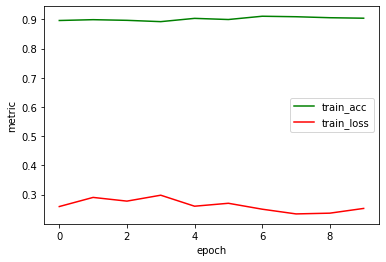

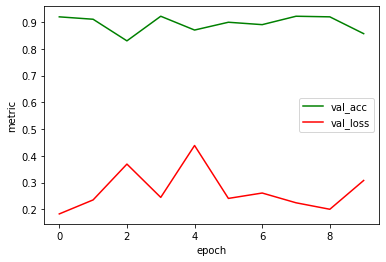

In [0]:
plot_acc_loss(history.history)

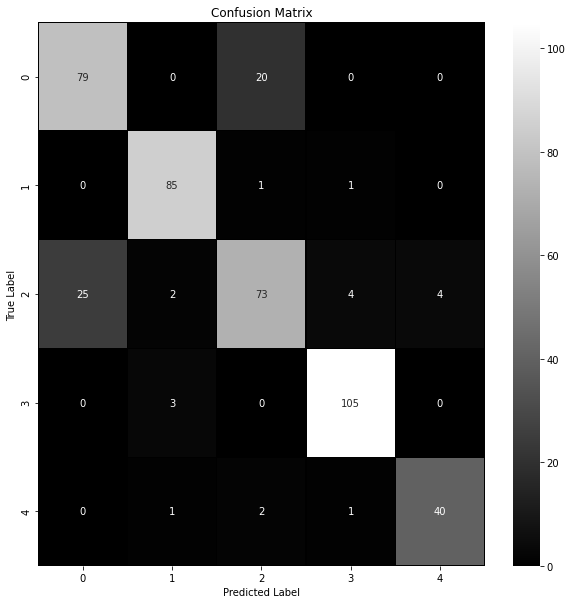

In [0]:
plot_confusion_matrix(model,X_test,Y_test)

As expected, since we increased the size of the dataset the accuracy is also improved from **91%** to **92%**. Futhermore, the misprediction ratio has also decreased for all the classes.

#Try to apply transfer Learning using VGG16

[official documentation](https://keras.io/applications/#vgg16)

[original paper](https://arxiv.org/abs/1409.1556)

In [0]:
from keras.applications import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape= new_shape, pooling=None, classes=1000)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(nb_classes,activation='softmax')(x) #final layer with softmax activation

In [0]:
model=Model(inputs=base_model.input,outputs=preds)

####check the architechture of the define model

In [0]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_1
21 dense_2
22 dense_3
23 dense_4


###Set trainable flag of convolutional layers to false

In [0]:
for layer in model.layers[:20]:
    layer.trainable=False

In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
n_epochs = 30
batch_size = 64

history = model.fit_generator(
    train_datagen.flow(x= X_train_new, y = Y_train_new, batch_size=batch_size, shuffle=True),
    validation_data = (X_test, Y_test),
    steps_per_epoch=ceil(len(X_train)/ batch_size),
    epochs=n_epochs,
    verbose = 1
)

Epoch 1/30
28/28 [==============================] - 3s 120ms/step - loss: 3.2975 - accuracy: 0.5843 - val_loss: 0.5262 - val_accuracy: 0.8139
Epoch 2/30
28/28 [==============================] - 2s 84ms/step - loss: 0.5407 - accuracy: 0.8022 - val_loss: 0.4915 - val_accuracy: 0.8139
Epoch 3/30
28/28 [==============================] - 2s 82ms/step - loss: 0.4817 - accuracy: 0.8185 - val_loss: 0.3315 - val_accuracy: 0.8834
Epoch 4/30
28/28 [==============================] - 2s 81ms/step - loss: 0.3878 - accuracy: 0.8577 - val_loss: 0.3176 - val_accuracy: 0.8655
Epoch 5/30
28/28 [==============================] - 2s 79ms/step - loss: 0.3865 - accuracy: 0.8532 - val_loss: 0.3447 - val_accuracy: 0.8901
Epoch 6/30
28/28 [==============================] - 3s 93ms/step - loss: 0.3645 - accuracy: 0.8655 - val_loss: 0.2892 - val_accuracy: 0.8946
Epoch 7/30
28/28 [==============================] - 2s 77ms/step - loss: 0.3169 - accuracy: 0.8867 - val_loss: 0.2606 - val_accuracy: 0.8924
Epoch 8/30
2

In [0]:
plot_acc_loss(history.history)

In [0]:
plot_confusion_matrix(model, X_test, Y_test)

NOTE: When we freeze the weigths of the CNN layers and train only the ones of the dense layers, the performances achieved by VGG16 network are quite similar to the one obtained with our basic network. However, this network have some advantages because it's easier to train(less trainable parmeters).